# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Add the parent directory to the Python path - bad practice, but it's just for the example
import sys
sys.path.append("..")

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.datasets.DLR_dataset import DatasetDLR
from src.plot_crp_explanations import plot_explanations, plot_one_image_explanation
from src.minio_client import MinIOClient
from LCRP.models import get_model 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# AUTH

## Loading dataset and model

In [4]:
# Define transformation (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load dataset
root_dir = "../data/General_Flood_v3/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)

model_name = "unet"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading unet with path to checkpoint
model = get_model(model_name=model_name, classes=2, ckpt_path="../models/unet_flood_modified.pt")

Loaded checkpoint ../models/unet_flood_modified.pt


## Running analysis and plotting results

In [5]:
output_dir = "../output/crp/unet_flood"

In [ ]:
# run_analysis(model_name, model, dataset, output_dir=output_dir, device=device)

torch.Size([3, 480, 480])
Concepts: torch.return_types.topk(
values=tensor([0.0124, 0.0106, 0.0106]),
indices=tensor([ 17, 119,  31]))
Computing reference images...


KeyboardInterrupt: 

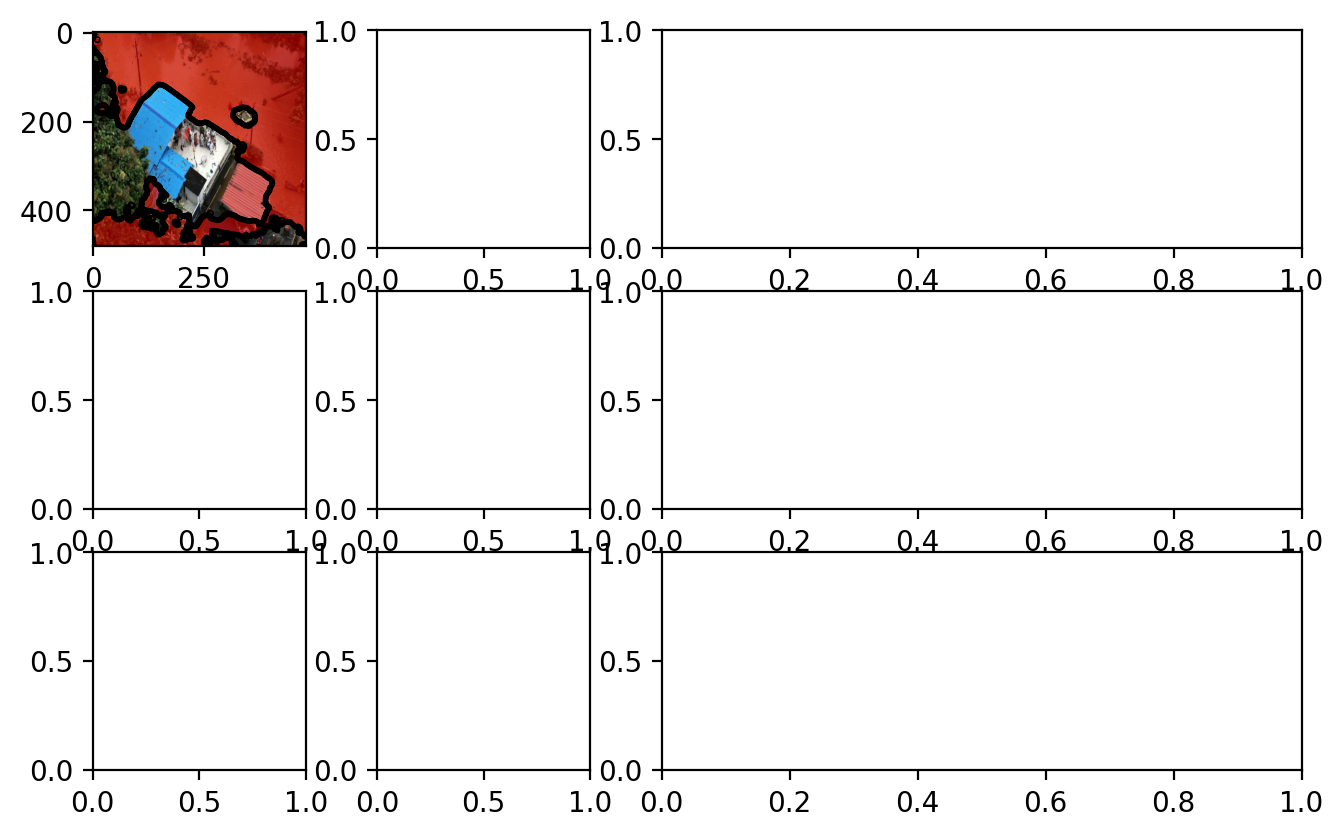

In [7]:
# Setting up main parameters
class_id = 1
sample_id = 100
n_concepts = 3
n_refimgs = 12
layer = "encoder.features.15"
mode = "relevance"
prediction_num = 0

# if failing, try to restart the notebook and do not run analysis again, go directly to plotting
plot_explanations(model_name, model, dataset, sample_id, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)

Trying the same with a test image

In [14]:
minio_client = MinIOClient()

In [15]:
test_image = minio_client.download_image("naples",  "DJI_20240604120105_0012_V.JPG")

Image downloaded and converted to numpy array successfully.


/Users/kortukov/miniconda3/envs/tema/lib/python3.8/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
/Users/kortukov/miniconda3/envs/tema/lib/python3.8/site-packages/zennit/image.py:188: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).clip(0, 255).astype(np.uint8)


Concepts: torch.return_types.topk(
values=tensor([0., 0., 0.]),
indices=tensor([2, 0, 1]))
Computing reference images...
Plotting...


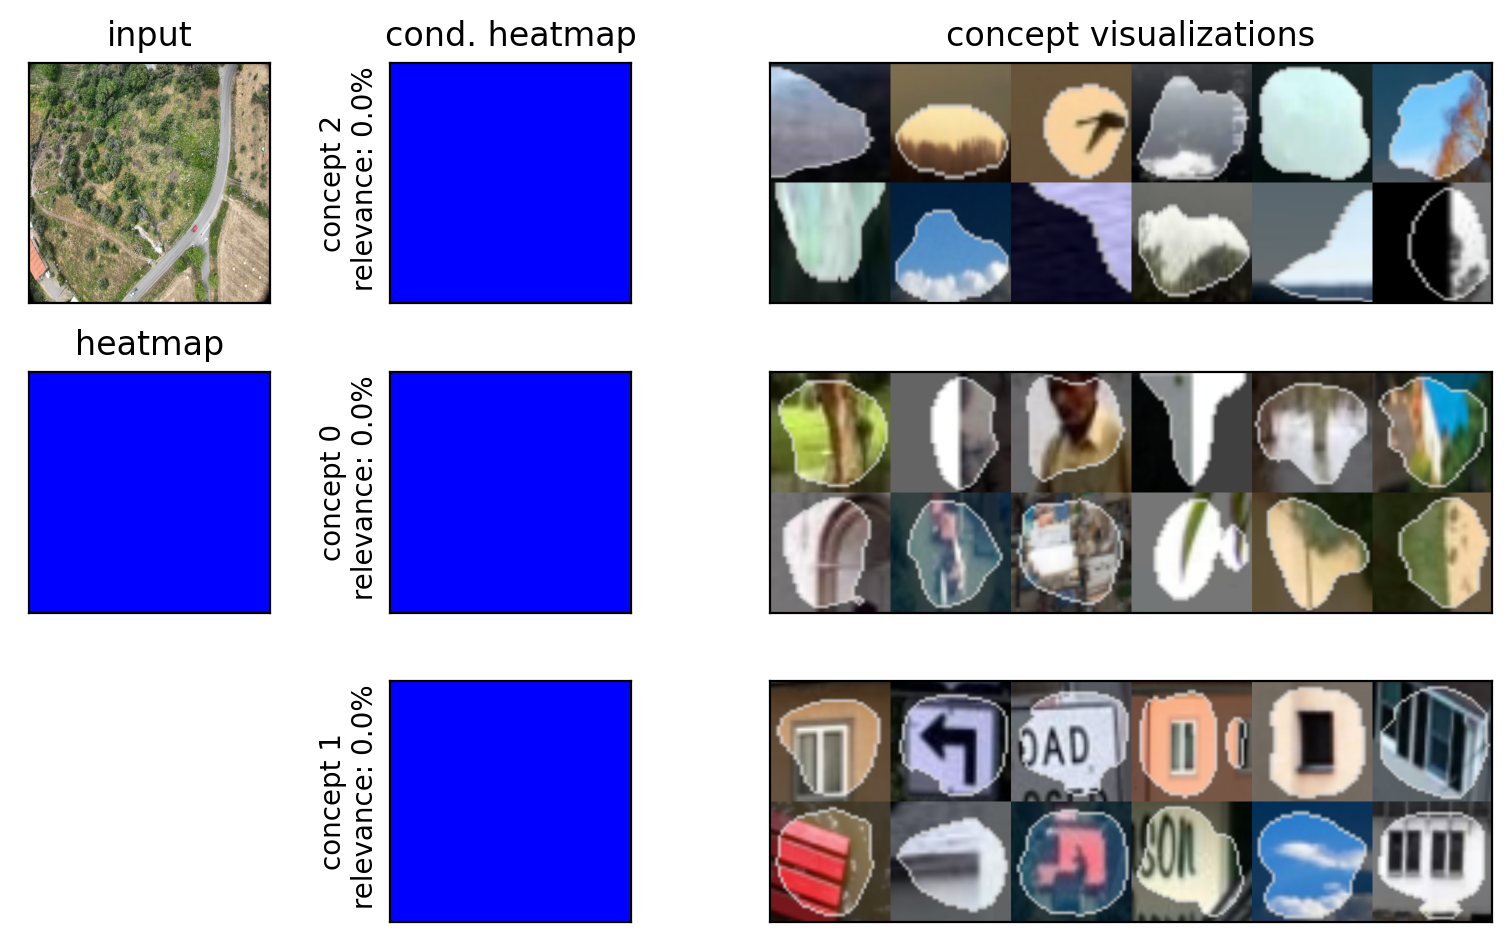

In [17]:

image_tensor = dataset.transform(test_image)
image_tensor = dataset.resize(image_tensor)

# Generate explanation
explanation_fig = plot_one_image_explanation(
    model_name, model, image_tensor, dataset, 
    class_id, layer, prediction_num, mode, n_concepts, n_refimgs, 
    output_dir=output_dir
)

## Dataset Visualization

Just in case

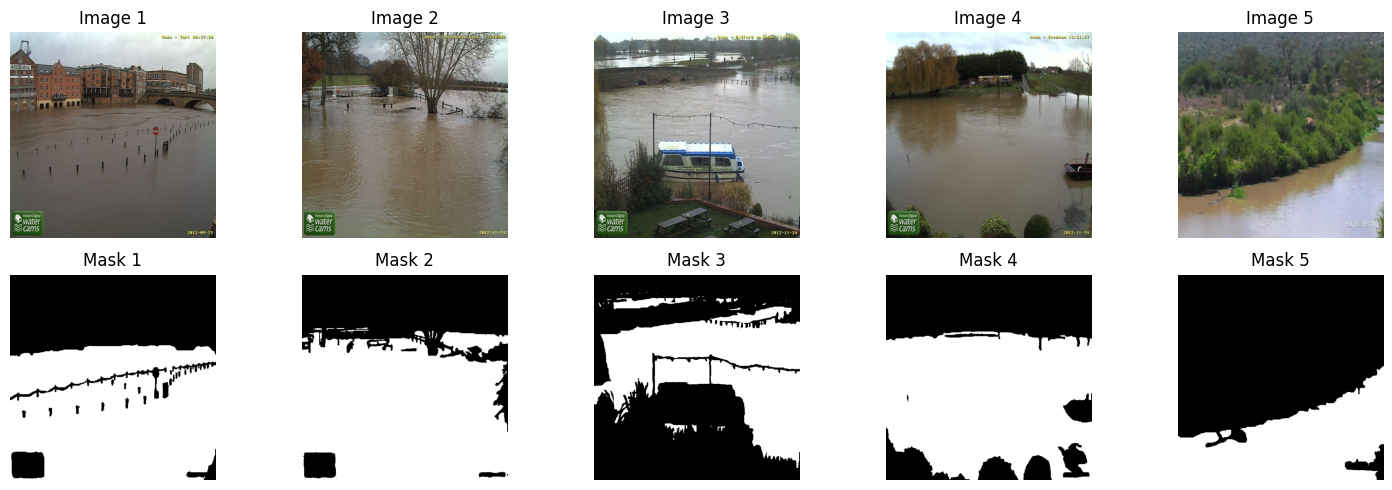

Dataset size: 1321


In [ ]:
# Define transformation (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load dataset
root_dir = "../datasets/data/General_Flood_v3/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)

# Visualize 5 images and their masks
num_images = 5
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))  # 2 rows (Images, Masks)

for i in range(num_images):
    image, mask = dataset[i]  # Get image-mask pair
    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    mask = mask.squeeze().numpy()  # Remove channel dim

    # Top row: Images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")

    # Bottom row: Masks
    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

print(f"Dataset size: {len(dataset)}")

# DLR

## Loading dataset and model

In [4]:
model = get_model(model_name="unet", device=device, classes=1, ckpt_path="../models/checkpoints/model_s2burnt_modified.pt", in_channels=4, encoder_name="resnet50")

dataset = DatasetDLR(
    img_dir="../datasets/data/fire_data_DLR/train_tiled/img", 
    mask_dir="../datasets/data/fire_data_DLR/train_tiled/msk", 
    normalize_means_stds=[
        [0.1161, 0.1065, 0.1036, 0.2059],  # Means
        [0.0556, 0.0570, 0.0772, 0.1033]   # Stds
    ]
)

Loaded checkpoint ../models/checkpoints/model_s2burnt_modified.pt


Loading masks: 100%|██████████| 731/731 [00:00<00:00, 5539.43it/s]


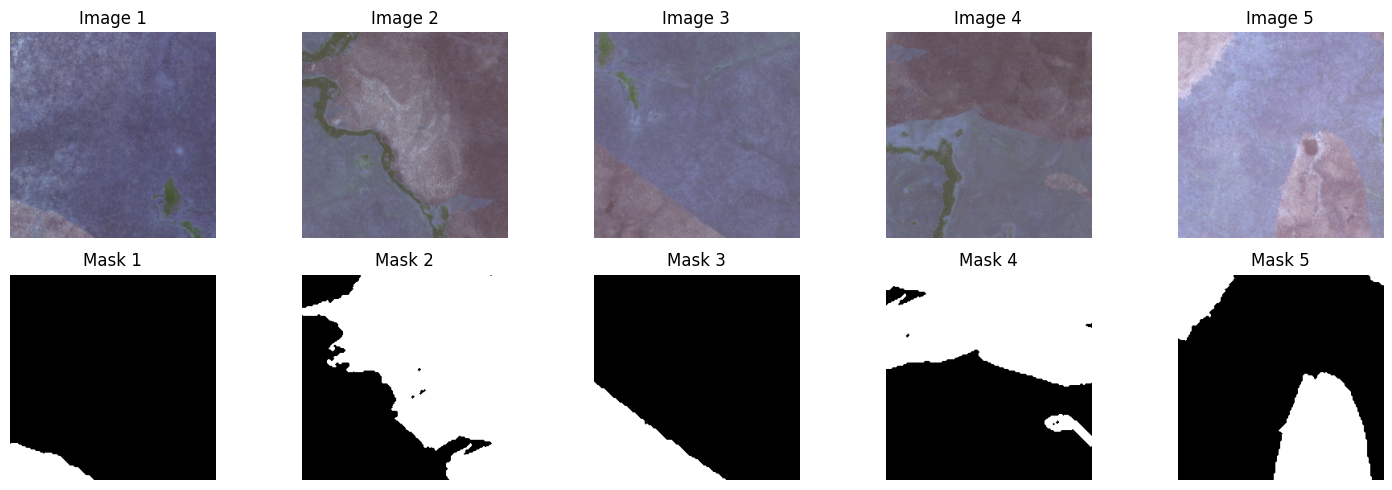

Dataset size: 731


In [5]:
# Visualize 5 images and their masks
num_images = 5
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))  # 2 rows (Images, Masks)

for i in range(num_images):
    image, mask = dataset[i + 5]  # Get image-mask pair
    image = np.array(((image - image.min()) / (image.max() - image.min()) * 255)).astype(np.uint8)
    image = np.transpose(image[:3, :, :].astype(int), (1, 2, 0))  # Convert to (H, W, C)
    mask = mask.squeeze() # Remove channel dim

    # Top row: Images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")

    # Bottom row: Masks
    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

print(f"Dataset size: {len(dataset)}")

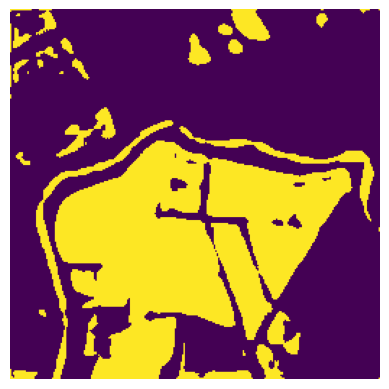

In [6]:
image, mask = dataset[2]
p = model.predict(image.unsqueeze(0))
res = np.array(p[0])
res = (res - res.min()) / (res.max() - res.min())
plt.axis('off')
plt.imshow(res[0] > 0.5)

In [21]:
run_analysis("unet", model, dataset, output_dir="output/crp/unet_fire_DLR", device=device)

Running Analysis...


  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [07:47<00:00,  5.08s/it]


100%|██████████| 64/64 [00:00<00:00, 1966.76it/s]


Concepts: torch.return_types.topk(
values=tensor([0.0102, 0.0096, 0.0079]),
indices=tensor([706, 140, 531]))
Computing reference images...
Plotting...



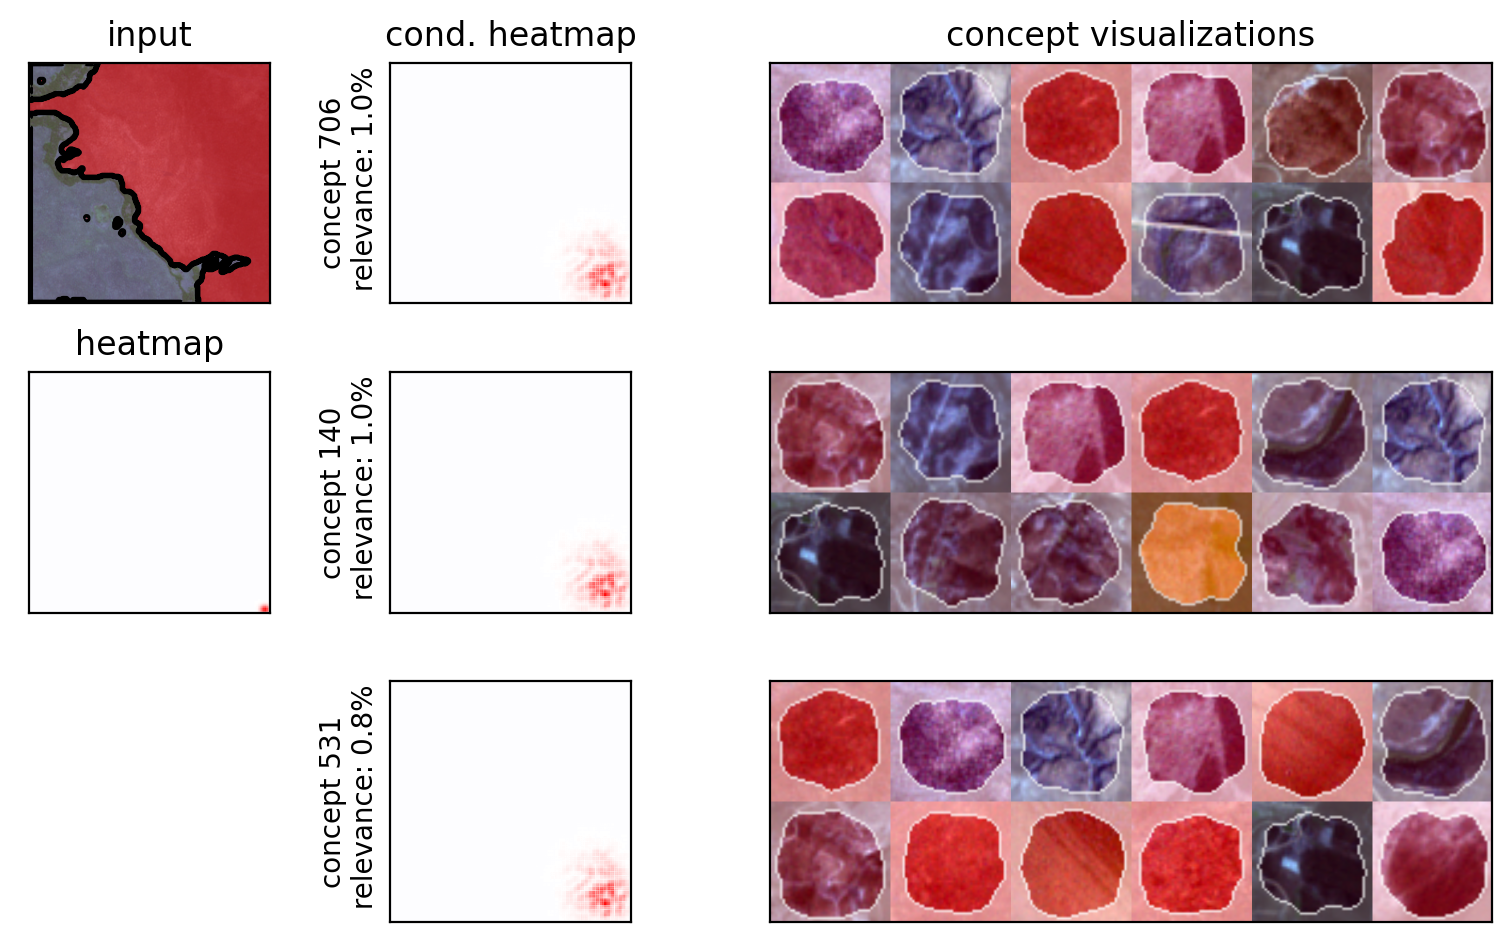

Done plotting.


In [24]:
# Setting up main parameters
model_name = "unet"
output_dir = "output/crp/unet_fire_DLR"
class_id = 0
sample_id = 6
n_concepts = 3
n_refimgs = 12
layer = "encoder.layer3.0.conv3"
mode = "relevance"
prediction_num = 0

# if failing, try to restart the notebook and do not run analysis again, go directly to plotting
plot_explanations(model_name, model, dataset, sample_id, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)